<a href="https://colab.research.google.com/github/apof/ChAI---GPs---Master-Thesis/blob/main/Neural_Net_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy

In [2]:
a = torch.randn(32, 28, 100)
#[batch_size, in_channels, len]
m = nn.Conv1d(28, 14, 10) 
out = m(a)
print(out.shape)

m = nn.LeakyReLU(0.1)
output = m(out)

torch.Size([32, 14, 91])


In [3]:
batch_size= 256

In [4]:
def var(tensor):
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/SNLP/')
import utils

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/h_aluminium_vectors')
aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/h_aluminium_labels')
aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/h_aluminium_dates')

copper_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/h_copper_vectors')
copper_labels = joblib.load('drive/MyDrive/Thesis_Vectors/h_copper_labels')
copper_dates = joblib.load('drive/MyDrive/Thesis_Vectors/h_copper_dates')

'''aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_vectors')
aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_labels')
aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_dates')

copper_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/copper_vectors')
copper_labels = joblib.load('drive/MyDrive/Thesis_Vectors/copper_labels')
copper_dates = joblib.load('drive/MyDrive/Thesis_Vectors/copper_dates')'''

dates = copper_dates

In [9]:
print(aluminium_inputs.shape)
print(aluminium_labels.shape)
print(aluminium_dates.shape)

print(copper_inputs.shape)
print(copper_labels.shape)
print(copper_dates.shape)

(3718, 100, 28)
(3718,)
(3718,)
(3718, 100, 18)
(3718,)
(3718,)


In [10]:
def align_timeseries(aluminium_inputs,aluminium_labels,aluminium_dates,copper_inputs,copper_labels,copper_dates):
  
  al_in = []
  al_lbl = []
  d = []
  c_in = []
  c_lbl = []

  al_dict = {}

  for i,inp in enumerate(aluminium_inputs):
    al_dict[aluminium_dates[i]] = (inp,aluminium_labels[i])

  for i,inp in enumerate(copper_inputs):
    if(al_dict.get(copper_dates[i]) != None):
      al_in.append(al_dict.get(copper_dates[i])[0])
      al_lbl.append(al_dict.get(copper_dates[i])[1])
      c_in.append(inp)
      c_lbl.append(copper_labels[i])
      d.append(copper_dates[i])

  return np.array(al_in),np.array(al_lbl),np.array(c_in),np.array(c_lbl),d



In [11]:
#aluminium_inputs,aluminium_labels,copper_inputs,copper_labels,dates =  align_timeseries(aluminium_inputs,aluminium_labels,aluminium_dates,copper_inputs,copper_labels,copper_dates)

In [12]:
print(aluminium_inputs.shape)
print(aluminium_labels.shape)

print(copper_inputs.shape)
print(copper_labels.shape)

print(len(dates))

(3718, 100, 28)
(3718,)
(3718, 100, 18)
(3718,)
3718


In [13]:
al_train_batches,al_validation_batches,al_test_batches = utils.train_test_split(aluminium_inputs,aluminium_labels,dates,aluminium_inputs.shape[0],0.8,0.5,0)

In [14]:
c_train_batches,c_validation_batches,c_test_batches = utils.train_test_split(copper_inputs,copper_labels,dates,copper_inputs.shape[0],0.8,0.5,0)

In [15]:
al_train_data,al_train_labels,al_train_dates = al_train_batches[0]
al_test_data,al_test_labels,al_test_dates = al_test_batches[0]
al_val_data,al_val_labels,al_val_dates = al_validation_batches[0]
#print("Train Dates: " + al_train_dates[0] + " " + al_train_dates[-1])
#print("Val Dates: " + al_val_dates[0] + " " + al_val_dates[-1])
#print("Test Dates: " + al_test_dates[0] + " " + al_test_dates[-1])

In [16]:
n = int(len(al_train_data)/batch_size)
index = n*batch_size
al_train_data = al_train_data[0:index]
al_train_labels = al_train_labels[0:index]
al_train_dates = al_train_dates[0:index]
al_test_data = al_test_data[0:batch_size]
al_test_labels = al_test_labels[0:batch_size]
al_test_dates = al_test_dates[0:batch_size]
al_val_data = al_val_data[0:batch_size]
al_val_labels = al_val_labels[0:batch_size]
al_val_dates = al_val_dates[0:batch_size]

In [17]:
c_train_data,c_train_labels,c_train_dates = c_train_batches[0]
c_test_data,c_test_labels,c_test_dates = c_test_batches[0]
c_val_data,c_val_labels,c_val_dates = c_validation_batches[0]
#print("Train Dates: " + c_train_dates[0] + " " + c_train_dates[-1])
#print("Val Dates: " + c_val_dates[0] + " " + c_val_dates[-1])
#print("Test Dates: " + c_test_dates[0] + " " + c_test_dates[-1])

n = int(len(al_train_data)/batch_size)
index = n*batch_size
c_train_data = c_train_data[0:index]
c_train_labels = c_train_labels[0:index]
c_train_dates = c_train_dates[0:index]
c_test_data = c_test_data[0:batch_size]
c_test_labels = c_test_labels[0:batch_size]
c_test_dates = c_test_dates[0:batch_size]
c_val_data = c_val_data[0:batch_size]
c_val_labels = c_val_labels[0:batch_size]
c_val_dates = c_val_dates[0:batch_size]

In [18]:
al_train_data = torch.from_numpy(al_train_data).to(dtype=torch.float16).to(device)
al_train_labels = torch.from_numpy(al_train_labels).to(device)
al_test_data = torch.from_numpy(al_test_data).to(dtype=torch.float16).to(device)
al_test_labels = torch.from_numpy(al_test_labels).to(device)
al_val_data = torch.from_numpy(al_val_data).to(dtype=torch.float16).to(device)
al_val_labels = torch.from_numpy(al_val_labels).to(device)

In [19]:
c_train_data = torch.from_numpy(c_train_data).to(dtype=torch.float16).to(device)
c_train_labels = torch.from_numpy(c_train_labels).to(device)
c_test_data = torch.from_numpy(c_test_data).to(dtype=torch.float16).to(device)
c_test_labels = torch.from_numpy(c_test_labels).to(device)
c_val_data = torch.from_numpy(c_val_data).to(dtype=torch.float16).to(device)
c_val_labels = torch.from_numpy(c_val_labels).to(device)

In [20]:
al_train_labels = torch.reshape(al_train_labels, (al_train_labels.shape[0], 1))
al_test_labels = torch.reshape(al_test_labels, (al_test_labels.shape[0], 1))
al_val_labels = torch.reshape(al_val_labels, (al_val_labels.shape[0], 1))

In [21]:
c_train_labels = torch.reshape(c_train_labels, (c_train_labels.shape[0], 1))
c_test_labels = torch.reshape(c_test_labels, (c_test_labels.shape[0], 1))
c_val_labels = torch.reshape(c_val_labels, (c_val_labels.shape[0], 1))

In [22]:
print(al_train_data.shape)
print(al_train_labels.shape)
print(al_test_data.shape)
print(al_test_labels.shape)
print(al_val_data.shape)
print(al_val_labels.shape)

torch.Size([2816, 100, 28])
torch.Size([2816, 1])
torch.Size([256, 100, 28])
torch.Size([256, 1])
torch.Size([256, 100, 28])
torch.Size([256, 1])


In [23]:
print(c_train_data.shape)
print(c_train_labels.shape)
print(c_test_data.shape)
print(c_test_labels.shape)
print(c_val_data.shape)
print(c_val_labels.shape)

torch.Size([2816, 100, 18])
torch.Size([2816, 1])
torch.Size([256, 100, 18])
torch.Size([256, 1])
torch.Size([256, 100, 18])
torch.Size([256, 1])


In [24]:
joint_train_labels = torch.cat((al_train_labels, c_train_labels), 1)
joint_valid_labels = torch.cat((al_val_labels, c_val_labels), 1)
joint_test_labels = torch.cat((al_test_labels, c_test_labels), 1)

In [25]:
print(joint_train_labels.shape)
print(joint_valid_labels.shape)
print(joint_test_labels.shape)

torch.Size([2816, 2])
torch.Size([256, 2])
torch.Size([256, 2])


In [26]:
train_set = torch.utils.data.TensorDataset(al_train_data, c_train_data, joint_train_labels)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [27]:
## define a dictionary with the parameters of the Neural Network
params_dictionary = {}
params_dictionary['embedding_size'] = (al_train_data[0].shape[1],c_train_data[0].shape[1])
params_dictionary['hidden_dim'] = 256
params_dictionary['linear_dims'] = [128,64]
params_dictionary['bidirectional'] = False
params_dictionary['label_size'] = 2
params_dictionary['dropout'] = 0.3
params_dictionary['rnn_layers_num'] = 1
params_dictionary['attention_layer'] = False
params_dictionary['concat_layer'] = [32]
params_dictionary['timesteps'] = al_train_data[0].shape[0]
params_dictionary['attention_layer'] = True
params_dictionary['kernel_size'] = 5
params_dictionary['cnn_reduced_dim'] = 25
params_dictionary['cnn_layer'] = True

In [28]:
class Attention(nn.Module):
    def __init__(self, device,hidden_size):
        super(Attention, self).__init__()
        self.device = device
        self.hidden_size = hidden_size

        self.concat_linear = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, hidden_size)

        ## add this model the same same device with the RNN
        self.to(device)

    def forward(self, rnn_outputs, final_hidden_state):
      attn_weights = self.attn(rnn_outputs) # (batch_size, seq_len, hidden_dim)
      attn_weights = torch.bmm(attn_weights, final_hidden_state.unsqueeze(2))
      attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
      context = torch.bmm(rnn_outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
      attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, final_hidden_state), dim=1)))
      return attn_hidden, attn_weights

In [29]:
class RnnRegressor(nn.Module):
    def __init__(self, device, params_dictionary,index):
        super(RnnRegressor, self).__init__()
        self.params = params_dictionary
        self.device = device

        # Calculate number of directions
        self.num_directions = 2 if self.params.get('bidirectional') == True else 1

        # define an attention model
        # Choose attention model
        self.attention = Attention(self.device,self.params.get('hidden_dim')* self.num_directions)

        ## here store in a list all the dimensions of the layers rnn_output --> linear layers --> labels layer
        self.linear_dims = [self.params.get('hidden_dim') * self.num_directions] + self.params.get('linear_dims')

        # Work with LSTM cell for now
        self.rnn = nn.LSTM

        ## CNN layer
        self.conv1d = nn.Conv1d(self.params.get('embedding_size')[index],params_dictionary.get('cnn_reduced_dim'),params_dictionary.get('kernel_size'))
        self.activation_func = nn.LeakyReLU(0.1)

        ## define the RNN layer
        self.rnn = self.rnn(params_dictionary['cnn_reduced_dim'],
                            self.params.get('hidden_dim'),
                            num_layers=self.params.get('rnn_layers_num'),
                            bidirectional=self.params.get('bidirectional'),
                            dropout=float(self.params.get('dropout')),
                            batch_first=True)
        
        ## the hidden state of the RNN empty for now
        self.hidden = None
        
        # Define set of fully connected layers (Linear Layer + Activation Layer)
        ## this set of layers takes the output of the RNN or the Attention layer and applies a feedforward NN on it
        ## consecutive linear + Relu layers are applied (the final layer does not have a relu activation!)
        self.linears = nn.ModuleList()
        for i in range(0, len(self.linear_dims)-1):
            if self.params.get('dropout') > 0.0:
                self.linears.append(nn.Dropout(p=self.params.get('dropout')))
            linear_layer = nn.Linear(self.linear_dims[i], self.linear_dims[i+1])
            #self.init_weights(linear_layer)
            self.linears.append(linear_layer)
            self.linears.append(nn.Tanh())

        self.to(self.device)

    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

    def init_hidden(self, batch_size):
        return (torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device),
              torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device))
      

    def forward(self, inp):

        (inputs,stateful,hidden_state) = inp

        if(params_dictionary.get('cnn_layer') == True):
          inputs = inputs.view(inputs.shape[0], inputs.shape[2], inputs.shape[1])
          with torch.cuda.amp.autocast():
            cnn_processing_x = self.conv1d(inputs)
            cnn_processing_x = self.activation_func(cnn_processing_x)
          inputs = cnn_processing_x.view(cnn_processing_x.shape[0], cnn_processing_x.shape[2], cnn_processing_x.shape[1])

        batch_size, seq_len, embedding_size = inputs.shape

        embedded_inputs = inputs

        if(stateful == True):
          ## initialise the hidden state of the RNN
          self.hidden = self.init_hidden(batch_size)
        # use the previous hidden state to make the rnn stateful alomg the batches
        else:
          self.hidden = hidden_state


        ## pass the data through the recurrent layer
        rnn_output, self.hidden = self.rnn(embedded_inputs.float(), self.hidden)

        ## Collect last hidden state
        final_state = self.hidden[0].view(self.params.get('rnn_layers_num'), self.num_directions, batch_size, self.params.get('hidden_dim'))[-1]

        # Handle directions if more than one
        final_hidden_state = None
        ## in case we have only one direction
        if self.num_directions == 1:
            final_hidden_state = final_state.squeeze(0)
        ## in case we have 2 directions concatenate these two states
        elif self.num_directions == 2:
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1)  # Concatenate both states


        ## Attention Layer
        if(self.params.get('attention_layer') == False):
          X = final_hidden_state
        else:
          #rnn_output = rnn_output.permute(1, 0, 2)
          X, attention_weights = self.attention(rnn_output, final_hidden_state)

        # Push through linear layers
        for l in self.linears:
            X = l(X)


        if(self.hidden[0].shape[1] == batch_size ):
          hidden = (var(self.hidden[0].data), var(self.hidden[1].data))
        else:
          hidden = hidden_state

        return X, hidden

In [30]:
class MultiTaskModel(nn.Module):

  def __init__(self, device, params_dictionary):
        super(MultiTaskModel, self).__init__()

        self.params = params_dictionary
        self.device = device

        self.net1 = RnnRegressor(device,params_dictionary,0)
        self.net2 = RnnRegressor(device,params_dictionary,1)

        self.linear_dims = [self.params.get('linear_dims')[-1]*2] + self.params.get('concat_layer')
        self.linear_dims.append(self.params.get('label_size'))

        self.linears = nn.ModuleList()
        for i in range(0, len(self.linear_dims)-1):
            if self.params.get('dropout') > 0.0:
                self.linears.append(nn.Dropout(p=self.params.get('dropout')))
            linear_layer = nn.Linear(self.linear_dims[i], self.linear_dims[i+1])
            #self.init_weights(linear_layer)
            self.linears.append(linear_layer)
            if i == len(self.linear_dims) - 1:
                break
            self.linears.append(nn.Tanh())

        self.to(self.device)


  def multitask_reg(self,reg_rate,reg_type):
    params_1 = []
    params_2 = []
    for p in self.net1.parameters():
      params_1.append(p)
    for p in self.net2.parameters():
      params_2.append(p)

    subtracted_params = []
    added_squares = []
    for i,p1 in enumerate(params_1):
      if(i!=0):
        #print(str(p1.shape) + " " + str(params_2[i].shape))
        subtracted_params.append(torch.subtract(p1, params_2[i]))
        added_squares.append(torch.sqrt(torch.add(torch.square(p1),torch.square(params_2[i]))))

    #for p in subtracted_params:
    #  print(p.shape)

    reg = None
    if(reg_type == 'l2'):
      reg = sum(p.pow(2.0).sum() for p in subtracted_params)
    elif(reg_type == 'l1'):
      reg = sum(torch.norm(p, 1).sum() for p in subtracted_params)

    return reg_rate*reg

  def init_weights(self, layer):
    if type(layer) == nn.Linear:
      torch.nn.init.xavier_uniform_(layer.weight)
      layer.bias.data.fill_(0.01)

  
  def forward(self, inp):

    (inp_1,inp_2,stateful,hidden_state_1,hidden_state_2) = inp

    out_1,hidden_state_1 = self.net1.forward((inp_1,stateful,hidden_state_1))
    out_2,hidden_state_2 = self.net2.forward((inp_2,stateful,hidden_state_2))
    concatenated_output = torch.cat((out_1,out_2),dim=1)

    X = concatenated_output

    for l in self.linears:
      X = l(X)

    return X, hidden_state_1, hidden_state_2

In [31]:
model = MultiTaskModel(device,params_dictionary)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [32]:
#loss = nn.MSELoss()
loss = nn.L1Loss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.00001)

In [33]:
train_loss = []
valid_loss = []

training_iter = 10000
    
#for early stopping :
best_cost=1000000 
stop = False
last_improvement=0
require_improvement = 100
best_model = None
epoch = 0

reg_rate = 0.0001
regularisation = None
#regularisation = 'l2'
#regularisation = 'l1'

while epoch < training_iter and stop == False:
  epoch += 1
  loss_batches = []
  stateful_flag = True
  hidden1 = None
  hidden2 = None

  for batch_index,training_batch in enumerate (train_set_loader,0):

    al_input_batch,c_input_batch,joint_labels = training_batch
    optimizer.zero_grad()

    y_pred,hidden1,hidden2 = model.forward((al_input_batch,c_input_batch,stateful_flag,hidden1,hidden2))

    if(regularisation == None):
      single_loss = loss(y_pred,joint_labels.float()).to(device)
    else:
      single_loss = loss(y_pred,joint_labels.float()).to(device) + model.multitask_reg(reg_rate,regularisation)

    single_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_batches.append(single_loss.item())
    stateful_flag = False
  train_loss.append(np.mean(np.array(loss_batches[-1])))

  ## compute and store the validation loss
  valid_pred,_,_ = model.forward((al_val_data,c_val_data,stateful_flag,hidden1,hidden2))
  val_loss = loss(valid_pred,joint_valid_labels.float().to(device)).item()
  valid_loss.append(val_loss)

  print("epoch  " + str(epoch) + " " + str(train_loss[-1]))
  print("epoch  " + str(epoch) + " " + str(valid_loss[-1]))
  clear_output(wait=True)

  avg_cost = val_loss
  if avg_cost < best_cost:
    best_cost = avg_cost
    last_improvement = 0
    best_model_state = copy.deepcopy(model.state_dict())
    torch.save(best_model_state, 'drive/MyDrive/Thesis_Models/multitask_model.pt')
  else:
    last_improvement +=1
            
  if last_improvement > require_improvement:
    print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
    # Break out from the loop.
    stop = True
            

No improvement found during the last iterations, stopping optimization at epoch: 402


In [34]:
model = MultiTaskModel(device,params_dictionary)
model.load_state_dict(torch.load('drive/MyDrive/Thesis_Models/multitask_model.pt'))
model.eval()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


MultiTaskModel(
  (net1): RnnRegressor(
    (attention): Attention(
      (concat_linear): Linear(in_features=512, out_features=256, bias=True)
      (attn): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv1d): Conv1d(28, 25, kernel_size=(5,), stride=(1,))
    (activation_func): LeakyReLU(negative_slope=0.1)
    (rnn): LSTM(25, 256, batch_first=True, dropout=0.3)
    (linears): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Linear(in_features=256, out_features=128, bias=True)
      (2): Tanh()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): Tanh()
    )
  )
  (net2): RnnRegressor(
    (attention): Attention(
      (concat_linear): Linear(in_features=512, out_features=256, bias=True)
      (attn): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv1d): Conv1d(18, 25, kernel_size=(5,), stride=(1,))
    (activation_func): LeakyReLU(negative_slope=0.1)
    (rnn): LSTM(25

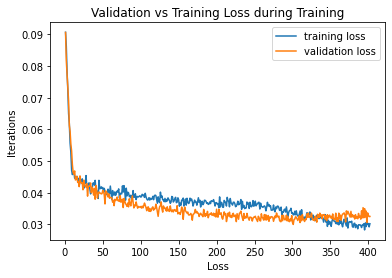

In [35]:
iters = [i+1 for i in range(len(train_loss))]
plt.plot(iters, train_loss ,label = "training loss")
plt.plot(iters, valid_loss, label = "validation loss")
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Validation vs Training Loss during Training')
plt.legend()
plt.show()

In [36]:
validation_predictions,_,_ = model.forward((al_val_data,c_val_data,None,hidden1,hidden2))
test_predictions,_,_ = model.forward((al_test_data,c_test_data,None,hidden1,hidden2))
joint_test_labels = joint_test_labels
joint_valid_labels = joint_valid_labels
joint_train_labels = joint_train_labels

In [37]:
train_predictions = []
for batch_index,training_batch in enumerate (train_set_loader,0):
    al_input_batch,c_input_batch,joint_labels = training_batch
    predictions,_,_ = model.forward((al_input_batch,c_input_batch,None,hidden1,hidden2))
    train_predictions.append(predictions.cpu().detach().numpy())

In [38]:
train_predictions = np.array(train_predictions)
print(train_predictions.shape)
train_predictions = np.reshape(train_predictions, (train_predictions.shape[0]*train_predictions.shape[1],train_predictions.shape[2]))
print(train_predictions.shape)

(11, 256, 2)
(2816, 2)


In [39]:
print(loss(validation_predictions,joint_valid_labels.float()))

tensor(0.0267, device='cuda:0', grad_fn=<L1LossBackward>)


In [40]:
index_1 = [i+1 for i in range(len(validation_predictions))]
index_2 = [i+1 for i in range(len(test_predictions))]
index_3 = [i+1 for i in range(len(train_predictions))]

In [41]:
validation_predictions = validation_predictions.cpu().detach().numpy()
joint_valid_labels = joint_valid_labels.cpu().detach().numpy()
test_predictions = test_predictions.cpu().detach().numpy()
joint_test_labels = joint_test_labels.cpu().detach().numpy()
joint_train_labels = joint_train_labels.cpu().detach().numpy()

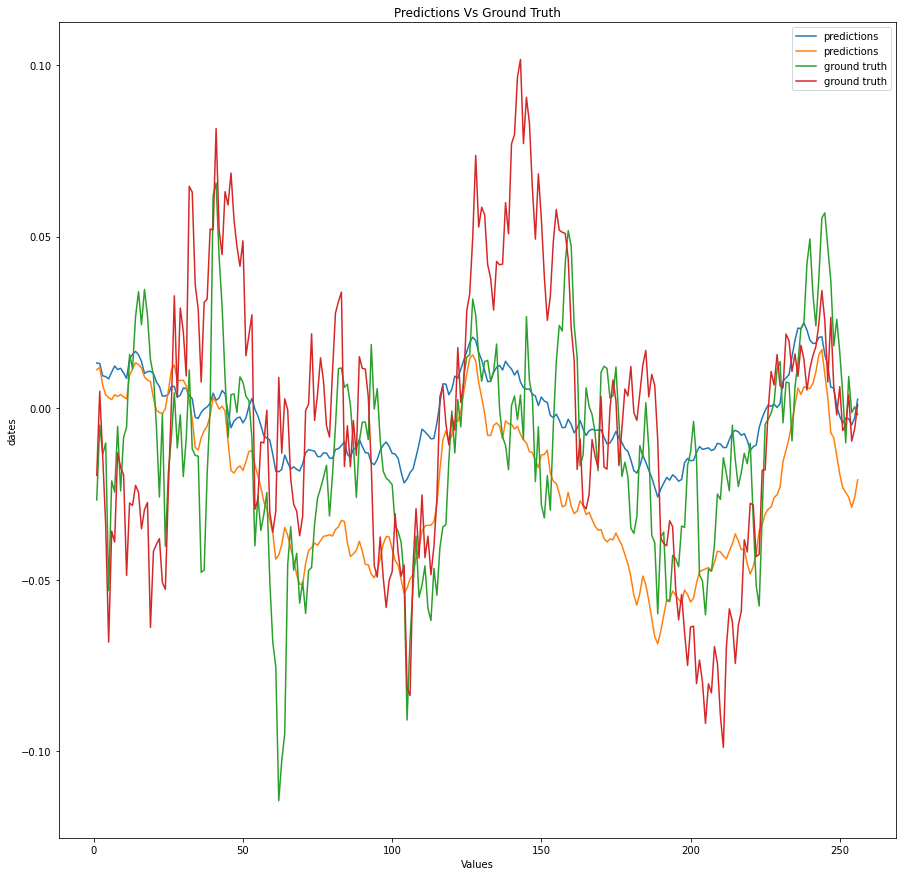

In [42]:
plt.figure(figsize=(15, 15))

plt.plot(index_1, validation_predictions ,label = "predictions")
plt.plot(index_1, joint_valid_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

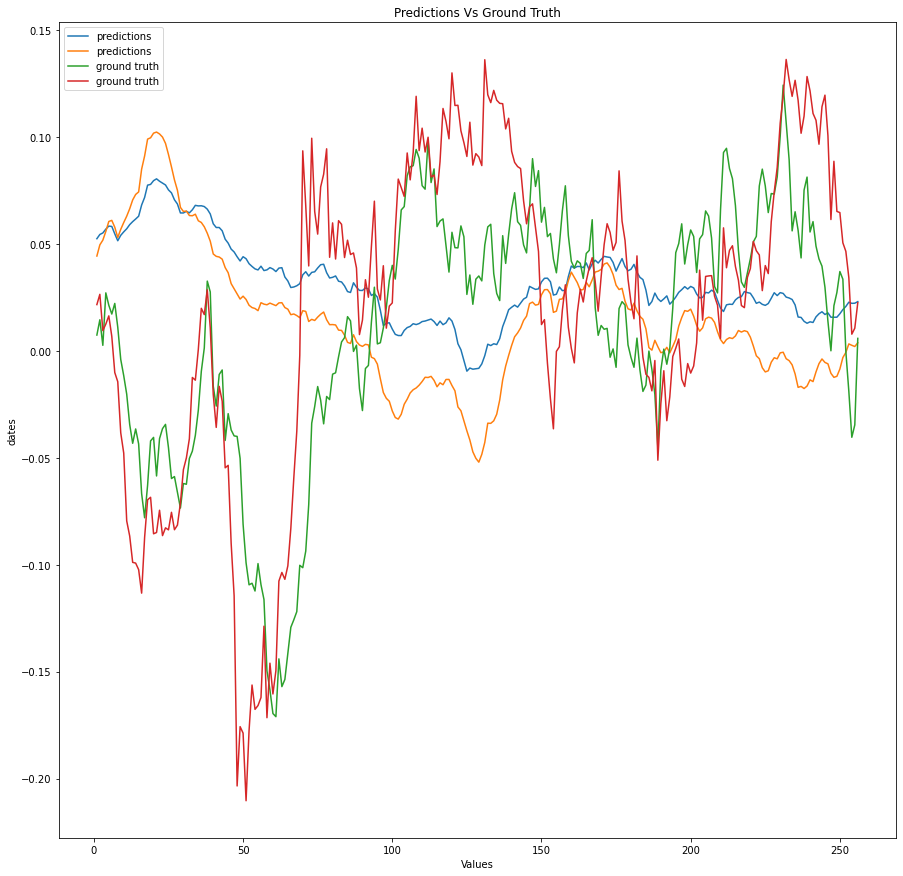

In [43]:
plt.figure(figsize=(15, 15))
plt.plot(index_2,  test_predictions,label = "predictions")
plt.plot(index_2, joint_test_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

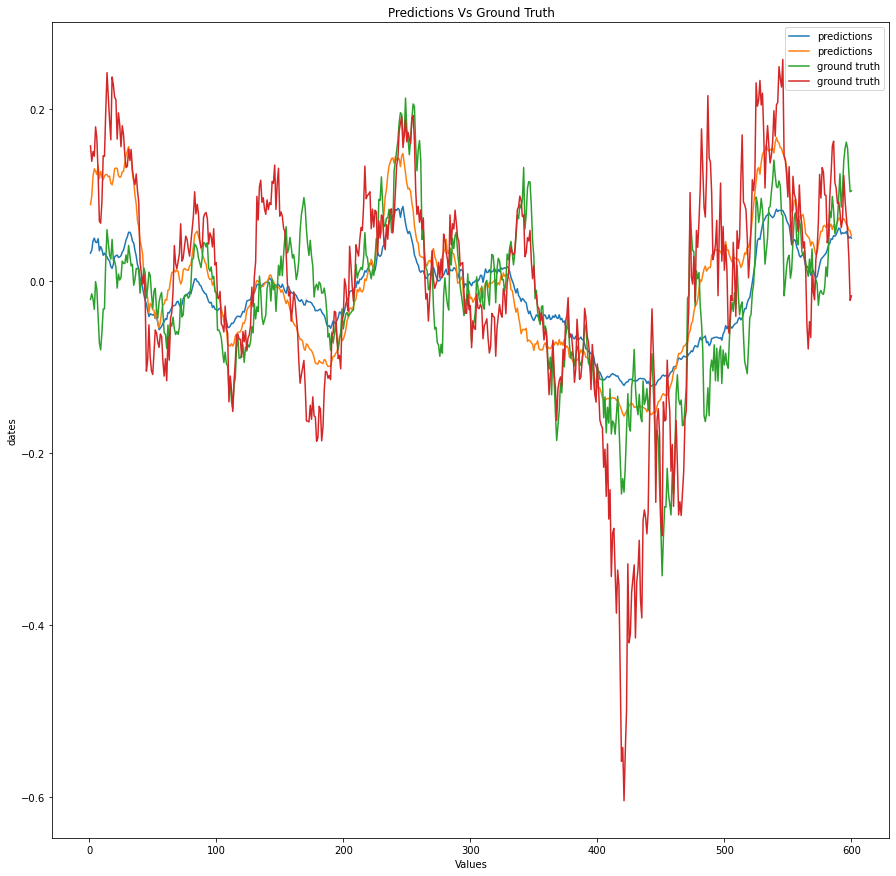

In [44]:
plt.figure(figsize=(15, 15))
plt.plot(index_3[0:600],  train_predictions[0:600],label = "predictions")
plt.plot(index_3[0:600], joint_train_labels[0:600], label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

In [45]:
print(joint_test_labels.shape)
print(test_predictions.shape)

(256, 2)
(256, 2)


In [46]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(joint_test_labels,test_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(test_predictions, joint_test_labels)))

Mean Directional Accuracy: 0.5431372549019607
Root Mean Squared Error : 0.08638679266272624


In [47]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(joint_valid_labels,validation_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(validation_predictions, joint_valid_labels)))

Mean Directional Accuracy: 0.6019607843137255
Root Mean Squared Error : 0.034309722787784616
